# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

In [1]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [3]:
!wget -nc https://raw.githubusercontent.com/Berenice2018/PySyft-Bc/master/syft/frameworks/torch/differential_privacy/pate.py

--2021-06-19 14:39:05--  https://raw.githubusercontent.com/Berenice2018/PySyft-Bc/master/syft/frameworks/torch/differential_privacy/pate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17194 (17K) [text/plain]
Saving to: ‘pate.py’

pate.py             100%[===================>]  16.79K  --.-KB/s    in 0s      

2021-06-19 14:39:05 (34.0 MB/s) - ‘pate.py’ saved [17194/17194]



In [4]:
!pip -q install 'tensorflow-privacy==0.5.2'
#!pip -q install git+https://github.com/tensorflow/privacy #TODO fix this

     |████████████████████████████████| 194kB 10.8MB/s 


##### Import libraries

In [5]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import os, random, shutil
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

from pate import perform_analysis
from progressbar import ProgressBar

import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SingleAttackResult
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [6]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:10, 73.5MB/s]


##### Define constants

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
TEST_SPLIT = 0.15
VAL_SPLIT = 0.05
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SHAPE = [256, 256, 3] # original dataset image size is 299x299x3

# PATE parameters
TEACHER_NB = 25
TEACHER_EPOCHS = 100
STUDENT_EPOCHS = 25
STUDENT_DS_SIZE = 999
NOISE_SCALE = 40.0
NOISE_EPSILON = 1 / NOISE_SCALE

SAVE_TEACHERS = True

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Create dataset

In [8]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [9]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [10]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [11]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [12]:
# create train-test split
x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size=TEST_SPLIT, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VAL_SPLIT, random_state=random_state)

In [13]:
# split off student training data
student_split = STUDENT_DS_SIZE / len(y_train)
x_teacher, x_student, y_teacher, y_student = train_test_split(x_train, y_train, test_size=student_split, random_state=random_state)

In [14]:
TEACHER_IMG_COUNT = len(y_teacher)
STUDENT_IMG_COUNT = len(y_student)
VAL_IMG_COUNT = len(y_val)
TEST_IMG_COUNT = len(y_test)
print(
    'Train teachers: ' + str(TEACHER_IMG_COUNT) + ',',
    'Train student: ' + str(STUDENT_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train teachers: 6300, Train student: 999, Val: 385, Test: 1356


In [15]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [16]:
TEACHER_DISTRIBUTION = get_distribution(y_teacher)
STUDENT_DISTRIBUTION = get_distribution(y_student)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('teacher train set: ', TEACHER_DISTRIBUTION)
print('student train set: ', STUDENT_DISTRIBUTION)
print('val set: ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

teacher train set:  {'normal': 3750, 'COVID-19': 2550}
student train set:  {'normal': 630, 'COVID-19': 369}
val set:  {'normal': 227, 'COVID-19': 158}
test set:   {'normal': 817, 'COVID-19': 539}


###### Dataset partition for teachers

In [17]:
def partition_dataset(x, y, nb_teachers, teacher_id):
    # Sanity checks
    assert len(x) == len(y)
    assert int(teacher_id) < int(nb_teachers)

    # This will floor the possible number of batches
    part_len = int(len(x) / nb_teachers)
    assert part_len >= BATCH_SIZE

    # Compute start, end indices of partition
    start = teacher_id * part_len
    end = (teacher_id+1) * part_len

    if teacher_id == nb_teachers-1:
        end = len(x)

    # Slice partition off
    train_partition = (x[start:end], y[start:end])

    return train_partition

In [18]:
teacher_data = [partition_dataset(x_teacher, y_teacher, TEACHER_NB, teacher_id) for teacher_id in range(TEACHER_NB)]
print("Teacher partitions: " + str(len(teacher_data)))
print("Length first train: " + str(len(teacher_data[0][1])))
print("Length last train: " + str(len(teacher_data[-1][1])))

Teacher partitions: 25
Length first train: 252
Length last train: 252


###### Create tensors

In [19]:
# build tensorflow datasets
teacher_files = []
for teacher_id in range(TEACHER_NB):
    train_data = teacher_data[teacher_id]
    teacher_files.append(tf.data.Dataset.from_tensor_slices(train_data))

train_files = tf.data.Dataset.from_tensor_slices((x_teacher, y_teacher))
student_files = tf.data.Dataset.from_tensor_slices((x_student, y_student))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [20]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [21]:
teacher_sets = []
for teacher_id in range(TEACHER_NB):
    train_files = teacher_files[teacher_id]
    teacher_sets.append(train_files.map(get_img, num_parallel_calls=AUTOTUNE))

train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
student_ds = student_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing

In [22]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Define data augmentation

In [23]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [24]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [25]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [26]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [27]:
# batch datasets
# teachers
TEACHER_IMG_CNTS = []
teacher_batched = []
for teacher_id in range(TEACHER_NB):
    teacher_ds = teacher_sets[teacher_id]
    TEACHER_IMG_CNTS.append(tf.data.experimental.cardinality(teacher_ds).numpy())
    teacher_batched.append(prepare_dataset(teacher_ds,
                                           pre=True,
                                           shuffle=True,
                                           repeat=True,
                                           batch=True,
                                           augment=True,
                                           cache='./data.tfcache'+str(teacher_id)))
# student
student_unbatched = prepare_dataset(student_ds,
                                    pre=True,
                                    shuffle=True,
                                    repeat=False,
                                    batch=False,
                                    augment=False,
                                    cache=False)
# seperate labels from images
student_data = []
student_labels = []
for x, y in tf.data.Dataset.as_numpy_iterator(student_unbatched):
    student_data.append(x)
    student_labels.append(y)
student_data = np.array(student_data)
student_labels = np.array(student_labels)

val_batched = prepare_dataset(val_ds,
                              pre=True,
                              shuffle=False,
                              repeat=False,
                              batch=True,
                              augment=False)
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [28]:
# set for attack on train set
train_attack_data = prepare_dataset(train_ds,
                                    pre=True,
                                    shuffle=True,
                                    repeat=False,
                                    batch=1,
                                    augment=False,
                                    cache=False)

# set for attack on test set
test_attack_data = prepare_dataset(test_ds,
                                   pre=True,
                                   shuffle=False,
                                   repeat=False,
                                   batch=1,
                                   augment=False,
                                   cache=False)

### Visualization

###### Distribution of labels in the sets

In [29]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

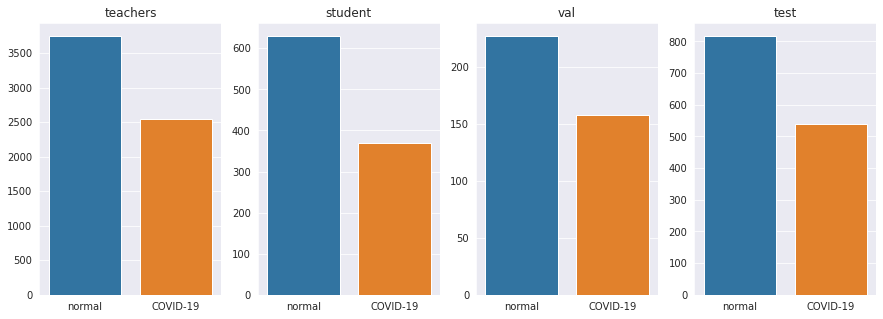

In [30]:
plot_distributions({'teachers': TEACHER_DISTRIBUTION, 'student': STUDENT_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [31]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [32]:
image_batch, label_batch = next(iter(teacher_batched[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


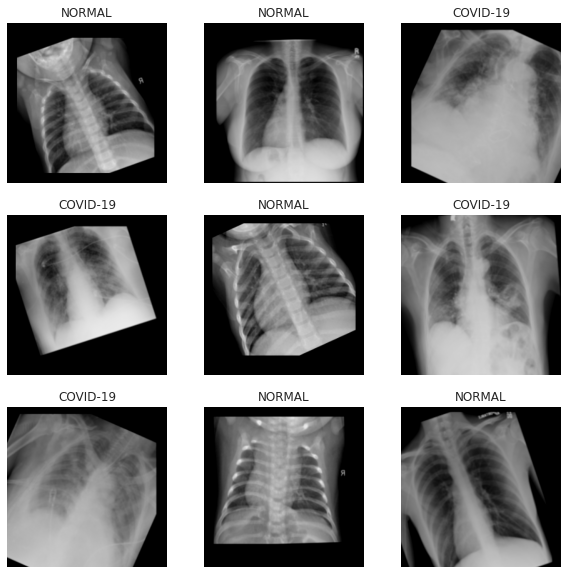

In [33]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [34]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [35]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

## Teachers ResNet18V2
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [36]:
def resnet_block(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    preact = BatchNormalization(epsilon=1.001e-5, name=name + '_preact_bn')(x)
    preact = Activation('relu', name=name + '_preact_relu')(preact)
    if conv_shortcut is True:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = MaxPooling2D(1, strides=stride)(x) if stride > 1 else x
    x = Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_relu')(x)
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = Add(name=name + '_out')([shortcut, x])
    return x

def resnet_stack(x, filters, blocks, stride1=2, name=None):
    x = resnet_block(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = resnet_block(x, filters, name=name + '_block' + str(i))
    x = resnet_block(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet(stack_fn, input, model_name='resnet'):
    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(input)
    x = Conv2D(64, 7, strides=2, use_bias=True, name='conv1_conv')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = MaxPooling2D(3, strides=2, name='pool1_pool')(x)
    x = stack_fn(x)
    x = BatchNormalization(epsilon=1.001e-5, name='post_bn')(x)
    x = Activation('relu', name='post_relu')(x)
    # Create model.
    model = tf.keras.models.Model(input, x, name=model_name)
    return model

def ResNet18V2(input):
    def stack_fn(x):
        x = resnet_stack(x, 16, 2, name='conv2')
        x = resnet_stack(x, 32, 2, name='conv3')
        x = resnet_stack(x, 64, 2, name='conv4')
        x = resnet_stack(x, 128, 2, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, input, 'resnet18v2')

In [37]:
def resnet18_builder(name='ResNet18V2'):
    # ResNet18V2 without head
    resnet18 = ResNet18V2(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])))
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet18, # add pretrained resnet layers to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name=name)
    
    return model

In [38]:
METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

teacher_models = []
for teacher_id in range(TEACHER_NB):
    resnet18_teacher = resnet18_builder()
    teacher_models.append(resnet18_teacher)
    teacher_models[teacher_id].compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [39]:
teacher_models[0].summary()

Model: "ResNet18V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_6 (ModuleWrap (None, 8, 8, 512)         897088    
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 513       
Total params: 897,601
Trainable params: 891,713
Non-trainable params: 5,888
_________________________________________________________________


### Training

In [40]:
path = 'resnet18_teachers'+str(TEACHER_NB)+'_epochs'+str(TEACHER_EPOCHS)
if SAVE_TEACHERS:
    if not os.path.exists(weights_path+path+'.zip'):
        os.mkdir(path)
        pbar = ProgressBar()
        teacher_histories = []
        for teacher_id in pbar(range(TEACHER_NB)):
            teacher_histories.append(teacher_models[teacher_id].fit(
                teacher_batched[teacher_id],
                steps_per_epoch=TEACHER_IMG_CNTS[teacher_id]//BATCH_SIZE,
                epochs=TEACHER_EPOCHS,
                validation_data=val_batched,
                validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
                class_weight=class_weight_dict,
                callbacks=[learning_rate_decay],
                verbose=0,
            ))
        pbar = ProgressBar()
        for teacher_id in pbar(range(TEACHER_NB)):
            # save weights
            teacher_models[teacher_id].save_weights(path+'/teacher_'+str(teacher_id)+'.h5')
        shutil.make_archive(weights_path+path, 'zip', path)
    else: # load weights
        pbar = ProgressBar()
        shutil.unpack_archive(weights_path+path+'.zip', path, 'zip')
        for teacher_id in pbar(range(TEACHER_NB)):
            teacher_models[teacher_id].load_weights(path+'/teacher_'+str(teacher_id)+'.h5')
else:
    pbar = ProgressBar()
    teacher_histories = []
    for teacher_id in pbar(range(TEACHER_NB)):
        teacher_histories.append(teacher_models[teacher_id].fit(
            teacher_batched[teacher_id],
            steps_per_epoch=TEACHER_IMG_CNTS[teacher_id]//BATCH_SIZE,
            epochs=TEACHER_EPOCHS,
            validation_data=val_batched,
            validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[learning_rate_decay],
            verbose=0,
        ))

100% (25 of 25) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


### Evaluation on test set

In [41]:
pbar = ProgressBar()
accs = []
for teacher_id in pbar(range(TEACHER_NB)):
    loss, acc, prec, rec = teacher_models[teacher_id].evaluate(test_batched, verbose=0)
    accs.append(acc)
print('Average teacher accuracy: %0.4f'%(np.mean(accs)))

100% (25 of 25) |########################| Elapsed Time: 0:01:50 Time:  0:01:50


Average teacher accuracy: 0.7662


## Aggregate student dataset

In [42]:
def ensemble_preds(nb_teachers, data):
  # Compute shape of array that will hold probabilities produced by each
  # teacher, for each training point, and each output class
  result_shape = (nb_teachers, len(data))
  # Create array that will hold result
  result = np.zeros(result_shape, dtype=np.float32)

  # Get predictions from each teacher
  pbar = ProgressBar()
  for teacher_id in pbar(range(nb_teachers)):
    # Get predictions on our training data and store in result array
    result[teacher_id] = [pred[0] for pred in teacher_models[teacher_id].predict(data, verbose=0)]

  return result

In [43]:
# get teacher predictions
teacher_preds = ensemble_preds(TEACHER_NB, student_data)
# turn probs into labels
teacher_preds = np.asarray(np.round(teacher_preds), dtype=np.int32)

100% (25 of 25) |########################| Elapsed Time: 0:00:29 Time:  0:00:29


In [44]:
def aggregate_noisy_max(preds, lap_scale):
  preds = preds.T
  labels = []
  for pred in preds:
    label_count = np.bincount(pred, minlength = 2)
    # convert to float for laplace
    label_count = np.asarray(label_count, dtype=np.float32)
    for i in range(len(label_count)):
      label_count[i] += np.random.laplace(loc=0.0, scale=lap_scale)
    noisy_labels = np.argmax(label_count)
    labels.append(noisy_labels)

  labels = np.asarray(labels, dtype=np.int32)
  return labels

In [45]:
# aggregate and add noise
aggregated_labels = aggregate_noisy_max(teacher_preds, NOISE_SCALE)

In [46]:
# test ensemble accuracy
assert len(aggregated_labels) == len(student_labels)
# Check against correct labels to compute correct guesses
correct = np.sum(aggregated_labels == student_labels)
# Divide by number of labels to obtain accuracy
agg_acc = float(correct) / len(student_labels)
print("Accuracy of the aggregated labels: %.4f"%(agg_acc))

Accuracy of the aggregated labels: 0.5666


In [47]:
student_aggregated_ds = tf.data.Dataset.from_tensor_slices((student_data, aggregated_labels))
student_aggregated_batched = prepare_dataset(student_aggregated_ds,
                                             pre=False,
                                             shuffle=False,
                                             repeat=True,
                                             augment=True,
                                             batch=True,
                                             cache='./data.tfcache_agg')

## Student ResNet18V2
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [48]:
resnet18 = resnet18_builder()

resnet18.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

### Training

In [49]:
history_resnet18 = resnet18.fit(
    student_aggregated_batched,
    steps_per_epoch=STUDENT_IMG_COUNT//BATCH_SIZE,
    epochs=STUDENT_EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
31/31 [==============================] - 24s 543ms/step - loss: 0.7165 - accuracy: 0.5002 - precision: 0.6683 - recall: 0.8030 - val_loss: 0.6984 - val_accuracy: 0.4115 - val_precision: 0.4115 - val_recall: 1.0000
Epoch 2/25
31/31 [==============================] - 14s 465ms/step - loss: 0.7014 - accuracy: 0.5215 - precision: 0.5104 - recall: 0.8347 - val_loss: 0.8096 - val_accuracy: 0.4115 - val_precision: 0.4115 - val_recall: 1.0000
Epoch 3/25
31/31 [==============================] - 14s 463ms/step - loss: 0.6970 - accuracy: 0.5428 - precision: 0.5266 - recall: 0.7698 - val_loss: 0.7446 - val_accuracy: 0.4115 - val_precision: 0.4115 - val_recall: 1.0000
Epoch 4/25
31/31 [==============================] - 14s 462ms/step - loss: 0.6936 - accuracy: 0.5220 - precision: 0.5115 - recall: 0.8698 - val_loss: 0.9782 - val_accuracy: 0.4115 - val_p

### Evaluation

###### Visualize performance

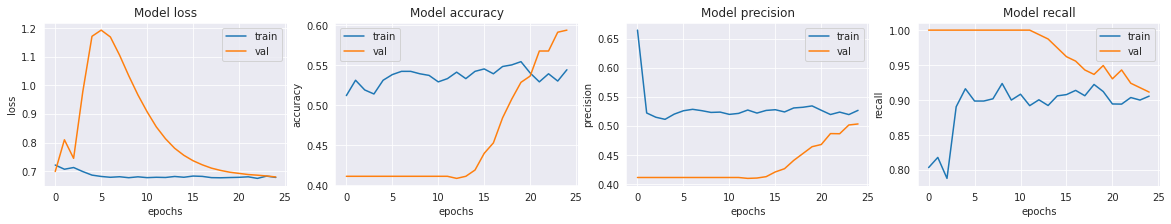

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet18.history[met])
    ax[i].plot(history_resnet18.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [51]:
loss, acc, prec, rec = resnet18.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 2s 39ms/step - loss: 0.6736 - accuracy: 0.5885 - precision: 0.4909 - recall: 0.9536
Loss of the model is -  0.6736337542533875
Accuracy of the model is -  58.849555253982544 %
Precision of the model is -  0.49092644453048706
Recall of the model is -  0.9536178112030029


## Student ResNet18V2 pre
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

In [52]:
resnet18_pre = resnet18_builder(name='ResNet18V2-pre')

resnet18_pre.load_weights(weights_path+'resnet18_relu_public_weights.h5') # load weights from pneumonia pretraining

resnet18_pre.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

### Training

In [53]:
history_resnet18_pre = resnet18_pre.fit(
    student_aggregated_batched,
    steps_per_epoch=STUDENT_IMG_COUNT//BATCH_SIZE,
    epochs=STUDENT_EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/25
31/31 [==============================] - 20s 504ms/step - loss: 0.9494 - accuracy: 0.5386 - precision: 0.5000 - recall: 0.8887 - val_loss: 1.1819 - val_accuracy: 0.4115 - val_precision: 0.4115 - val_recall: 1.0000
Epoch 2/25
31/31 [==============================] - 14s 469ms/step - loss: 0.7003 - accuracy: 0.5179 - precision: 0.5064 - recall: 0.8215 - val_loss: 2.0138 - val_accuracy: 0.4115 - val_precision: 0.4115 - val_recall: 1.0000
Epoch 3/25
31/31 [==============================] - 14s 477ms/step - loss: 0.6840 - accuracy: 0.5584 - precision: 0.5362 - recall: 0.8087 - val_loss: 0.8086 - val_accuracy: 0.4141 - val_precision: 0.4125 - val_recall: 1.0000
Epoch 4/25
31/31 [==============================] - 14s 471ms/step - loss: 0.6880 - accuracy: 0.5585 - precision: 0.5366 - recall: 0.8275 - val_loss: 1.6445 - val_accuracy: 0.4115 - val_precision: 0.4115 - val_recall: 1.0000
Epoch 5/25
31/31 [==============================] - 14s 466ms/step - loss: 0.6811 - accuracy: 0.5749

### Evaluation

###### Visualize performance

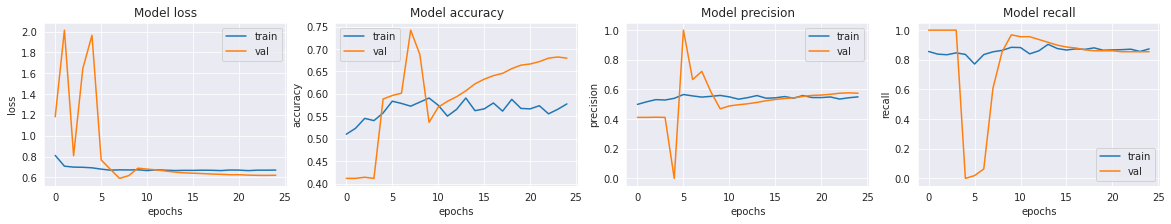

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet18_pre.history[met])
    ax[i].plot(history_resnet18_pre.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [55]:
loss, acc, prec, rec = resnet18_pre.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 2s 40ms/step - loss: 0.6122 - accuracy: 0.6976 - precision: 0.5782 - recall: 0.8850
Loss of the model is -  0.6121711134910583
Accuracy of the model is -  69.76401209831238 %
Precision of the model is -  0.578181803226471
Recall of the model is -  0.8849721550941467


## Evaluation

In [56]:
models = [
          resnet18,
          resnet18_pre,
]

### Model Analysis

In [57]:
for model in models:
    print("Evaluating %s ..." % (model.name))
    loss, acc, prec, rec = model.evaluate(test_batched)
    print('\n')

Evaluating ResNet18V2 ...
43/43 [==============================] - 2s 40ms/step - loss: 0.6736 - accuracy: 0.5885 - precision: 0.4909 - recall: 0.9536


Evaluating ResNet18V2-pre ...
43/43 [==============================] - 2s 41ms/step - loss: 0.6122 - accuracy: 0.6976 - precision: 0.5782 - recall: 0.8850




### Privacy Analysis

#### Compute epsilon

In [58]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [59]:
dde, die = perform_analysis(
    teacher_preds=teacher_preds,
    indices=aggregated_labels,
    noise_eps=NOISE_EPSILON,
    delta=DELTA,
    moments=8,
    beta=0.09
)
print("Data dependent epsilon = ", dde)
print("Data independent epsilon = ", die)

Data dependent epsilon =  8.065113457325458
Data independent epsilon =  8.065113457325396


For epsilons of 0.1, 0.5, 2, and 8 the laplace noise would have to be 2720, 549, 142, and 40, respectively.

#### Membership Inference Attack

In [60]:
def calc_attack_inputs(attack_data):
    bc = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant

    probs = []
    losses = []
    labels = []
    for x, y in tf.data.Dataset.as_numpy_iterator(attack_data):
        y = y[0]
        # predict
        pred = model.predict(x)[0]
        #pred = np.round(pred) # only label as output instead of prob
        probs.append(pred)
        # compute loss
        loss = bc(constant([y]), constant(pred), from_logits=False).numpy()[0]
        losses.append(loss)
        # get label
        labels.append(y)

    return np.array(probs), np.array(losses), np.array(labels)

In [61]:
# run membership inference attack
def run_mia(model, train_attack_data, test_attack_data):
    # get values for train set
    probs_train, loss_train, labels_train = calc_attack_inputs(train_attack_data)
    # get values for test set
    probs_test, loss_test, labels_test = calc_attack_inputs(test_attack_data)

    # prepare attacks
    attack_input = AttackInputData(
        probs_train = probs_train,
        probs_test = probs_test,
        loss_train = loss_train,
        loss_test = loss_test,
        labels_train = labels_train,
        labels_test = labels_test
    )

    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,
        by_percentiles = False,
        by_classification_correctness = True
    )

    attack_types = [
        #AttackType.THRESHOLD_ATTACK, # logistic was always better, so no threshold to save time
        AttackType.LOGISTIC_REGRESSION,
    ] 

    # run several attacks for different data slices
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                     slicing_spec=slicing_spec,
                                     attack_types=attack_types)

    # plot the ROC curve of the best classifier
    plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    plt.show()

    # print a user-friendly summary of the attacks
    print(attacks_result.summary(by_slices=False))

    # epsilon estimation based on attack, metric adapted for AUC from https://paperswithcode.com/paper/antipodes-of-label-differential-privacy-pate
    def empirical_eps(auc):
        if auc <= 0.5:
            return 0
        if auc == 1:
            return np.inf
        return np.log(auc / (1 - auc))

    # function to get lowest AUC result
    def get_result_with_min_auc(self) -> SingleAttackResult:
        aucs = [result.get_auc() for result in self.single_attack_results]
        return self.single_attack_results[np.argmin(aucs)]
    attacks_result.get_result_with_min_auc = get_result_with_min_auc

    min_auc = attacks_result.get_result_with_min_auc(attacks_result).get_auc()
    max_auc = attacks_result.get_result_with_max_auc().get_auc()
    eps_min_auc =  empirical_eps(min_auc) # lower bound
    eps_max_auc = empirical_eps(max_auc) # upper bound
    print('Empirical epsilon bounds from AUC: %0.2f, %0.2f'%(eps_min_auc, eps_max_auc))

Membership Inference Attack on ResNet18V2...
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier


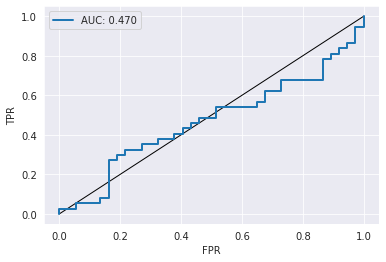

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 147 training and 147 test examples) achieved an AUC of 0.33 on slice CORRECTLY_CLASSIFIED=True
  LOGISTIC_REGRESSION (with 147 training and 147 test examples) achieved an advantage of 0.32 on slice CORRECTLY_CLASSIFIED=True
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Empirical epsilon bounds from AUC: 0.00, 0.00


Membership Inference Attack on ResNet18V2-pre...


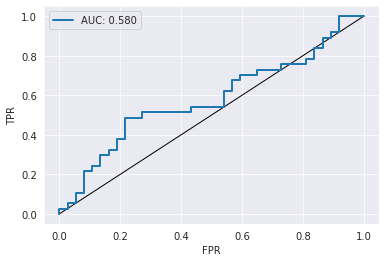

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 147 training and 147 test examples) achieved an AUC of 0.58 on slice CORRECTLY_CLASSIFIED=True
  LOGISTIC_REGRESSION (with 147 training and 147 test examples) achieved an advantage of 0.27 on slice CORRECTLY_CLASSIFIED=True
Empirical epsilon bounds from AUC: 0.00, 0.32




In [62]:
for model in models:
    print('Membership Inference Attack on '+model.name+'...')
    run_mia(model, train_attack_data, test_attack_data)
    print('\n')